In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from scipy.stats import norm

In [2]:
# Calculate monthly Total Returns for the S&P500 (includes dividends)
stock_ret = pd.read_csv('data_csv.csv')

# I want annual data so I keep only January of each year
mth_df = stock_ret.copy()
mth_df['year'] = [int(i.split('-')[0]) for i in mth_df['Date']]
mth_df['mth'] = [int(i.split('-')[1]) for i in mth_df['Date']]
mth_ret = mth_df['SP500']/mth_df['SP500'].shift(1) - 1
mth_df['mth_return'] = mth_ret #+ (mth_df['Dividend']*(1/12))/mth_df['SP500']

# Focus on post World War II period - THIS IS THE DATAFRAME THAT HOLDS MOST OF THE ANALYSIS DATA
modern_df = mth_df.loc[948:].copy()
modern_df['cum_return'] = np.cumprod(modern_df['mth_return']+1)

In [3]:
# Calculate the negative runs in the S&P 500 (from previous peak to the next peak)
# I use this to plot the declines graph (the red lined chart below)
neg_run = []
max_so_far = modern_df['cum_return'].iloc[0]                 # this variable stores the max return observed so far
for i, val in enumerate(modern_df['mth_return']):
    if i == 0:
        if val < 0:
            neg_run.append(val)
        else:
            neg_run.append(0)
    else:
        if modern_df['cum_return'].iloc[i] < max_so_far:     # if we have not yet regained the previous all time high
            neg_run.append((1 + neg_run[i-1])*(1 + val) - 1) # return then keep tallying the loss
        else:
            neg_run.append(0)                                # otherwise stop tallying the loss
            max_so_far = modern_df['cum_return'].iloc[i]

modern_df['neg_run'] = neg_run
# Convert date string to datetime format
modern_df['Date'] = pd.to_datetime(modern_df['Date'])

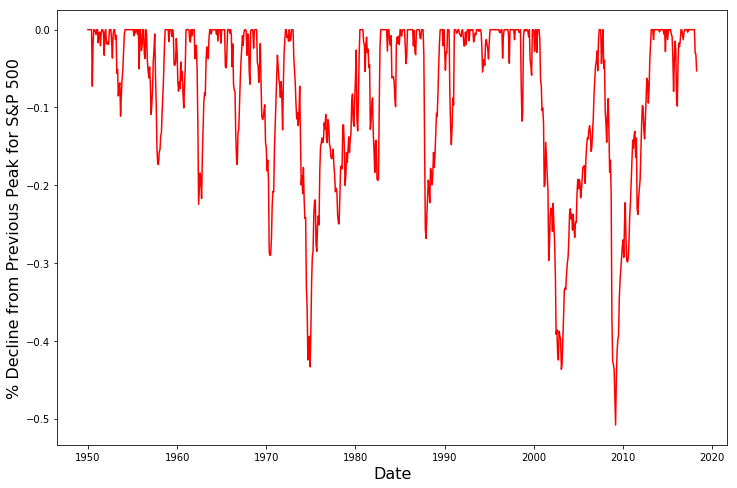

In [5]:
# Plot the cumulative declines from the previous all time high
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(x='Date', y='neg_run', data=modern_df, color='red');
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("% Decline from Previous Peak for S&P 500", fontsize=16)

plt.savefig(fname='decline_plot', dpi=150)

In [6]:
# Tag each cumulative decline (neg_run) with a integer label, for example the 5th neg_run would be tagged 5
# This label will be used later on in groupby's to investigate the characteristics of each decline
# neg_run goes from previous all time high to next all time high
label = 1
decline_num = []
first_seen = False
for i in modern_df['neg_run']:
    if i < 0:
        decline_num.append(label)
        first_seen = True
    else:
        decline_num.append(0)
        if first_seen:
            label += 1
            first_seen = False
            
modern_df['decline_num'] = decline_num

# Tag each peak to trough decline (neg_run) with a integer label
# pt_num identifies just the period from the previous all time high to the declines trough (lowest point)
label = 1
pt_num = []
found_min = False
for index, val in enumerate(modern_df['decline_num']):
    min_decline = min(modern_df[modern_df['decline_num']==val]['neg_run'])
    if val > 0:
        if found_min:
            pt_num.append(0)
        else:
            if modern_df.iloc[index]['neg_run'] == min_decline:
                found_min = True
                pt_num.append(val)
            else:
                pt_num.append(val)
    else:
        found_min = False
        pt_num.append(val)
            
modern_df['pt_num'] = pt_num

In [7]:
# Groupby's to check out the durations and maximum loss of each market decline identified
run_len = modern_df[modern_df['decline_num']>0].groupby(by='decline_num').count()['neg_run']
peak_decline = modern_df[modern_df['decline_num']>0].groupby(by='decline_num').min()['neg_run']
peak_trough_dur = modern_df[modern_df['pt_num']>0].groupby(by='pt_num').count()['neg_run']

# plt.plot(run_len.sort_values(ascending=False).reset_index(drop=True));

In [8]:
# Store groupby results in a new dataframe
declines_df = pd.DataFrame()

declines_df['run_len'] = run_len
declines_df['peak_decline'] = peak_decline
declines_df['peak_trough_dur'] = peak_trough_dur

# Bucket declines by magnitude
decline_bin = []
for i in peak_decline:
    if i >= 0.00:
        decline_bin.append(0)
    elif i >= -0.05:
        decline_bin.append(1)
    elif i >= -0.10:
        decline_bin.append(2)
    elif i >= -0.20:
        decline_bin.append(3)
    elif i >= -0.30:
        decline_bin.append(4)
    else:
        decline_bin.append(5)

declines_df['decline_bin'] = decline_bin

In [9]:
# Overall means for decline metrics
np.mean(declines_df)

run_len            7.597403
peak_decline      -0.060840
peak_trough_dur    3.805195
decline_bin        1.571429
dtype: float64

In [10]:
# Count the number of declines in each magnitude bucket
declines_df.groupby(by='decline_bin').count()['run_len']

decline_bin
1    55
2     9
3     7
4     3
5     3
Name: run_len, dtype: int64

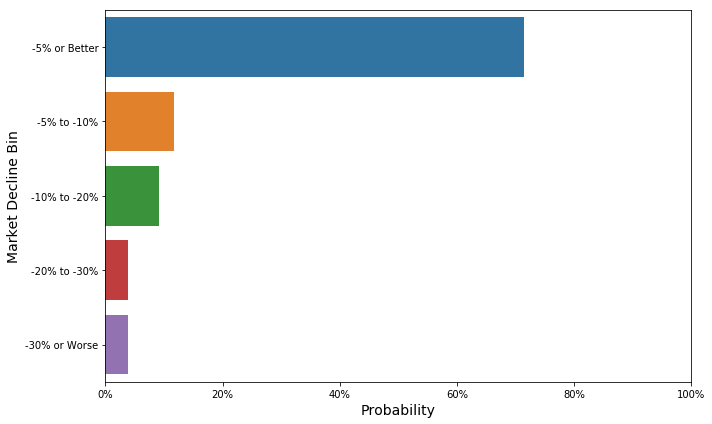

In [11]:
# Plot the number of declines in each magnitude bucket as a probability
prob_bucket = declines_df.groupby(by='decline_bin').count()['run_len']/sum(declines_df.groupby(by='decline_bin').count()['run_len'])
fig, ax = plt.subplots(figsize=(10,6))
bin_names = ['-5% or Better','-5% to -10%','-10% to -20%','-20% to -30%','-30% or Worse']
sns.barplot(x=prob_bucket, y=bin_names);
ax.set_xlabel("Probability",fontsize=14)
ax.set_ylabel("Market Decline Bin",fontsize=14)
ax.set_xlim(0, 1)

vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.savefig(fname='bar_prob_bins', dpi=150)

In [13]:
# Check out what happens after market has already dropped by 5%
worst_probs = prob_bucket[1:]/sum(prob_bucket[1:])
print(sum(worst_probs[1:]))     # probability of decline more than 10%
print(sum(worst_probs[2:]))     # probability of decline being more than 20%

0.5909090909090908
0.2727272727272727


In [14]:
# Check the mean decline in each bucket
declines_df.groupby(by='decline_bin').mean()['peak_decline']

decline_bin
1   -0.016313
2   -0.067592
3   -0.145376
4   -0.261054
5   -0.459432
Name: peak_decline, dtype: float64

In [15]:
# Check out the metrics of each bucket and store in a dataframe for plotting
duration_df = declines_df.groupby(by='decline_bin').mean()[['peak_trough_dur','run_len']]
duration_df.reset_index(inplace=True)
duration_df['recover_dur'] = duration_df['run_len'] - duration_df['peak_trough_dur']
duration_df

,decline_bin,peak_trough_dur,run_len,recover_dur
0,1,1.509091,1.909091,0.400000
1,2,4.111111,6.555556,2.444444
2,3,10.714286,15.428571,4.714286
3,4,9.333333,26.666667,17.333333
4,5,23.333333,77.666667,54.333333


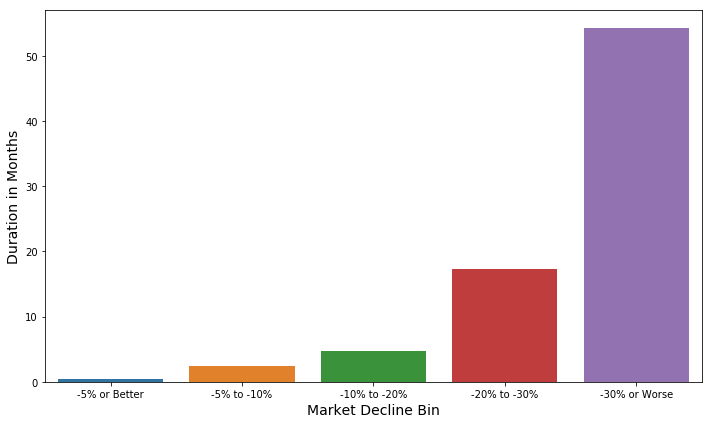

In [16]:
# Plot the metrics I am interestred in
fig, ax = plt.subplots(figsize=(10,6))
bin_names = ['-5% or Better','-5% to -10%','-10% to -20%','-20% to -30%','-30% or Worse']
sns.barplot(x=bin_names, y=duration_df['recover_dur'])
ax.set_xlabel("Market Decline Bin",fontsize=14)
ax.set_ylabel("Duration in Months",fontsize=14)

plt.tight_layout()
plt.savefig(fname='bar_plot_dur', dpi=150)

In [17]:
# Number and percentage of negative months
print(len([i for i in modern_df['mth_return'] if i<0]))
print(len([i for i in modern_df['mth_return'] if i<0])/modern_df.shape[0])

313
0.38170731707317074


In [18]:
# Mean length of decline
np.mean(declines_df['peak_trough_dur'])

3.8051948051948052